# Задача

Настало время применить VAE на практике! Давайте обучим вариационный автокодировщик генерации человеческого лица.
Для этого воспользуемся датасетом [Frey](https://lms-cdn.skillfactory.ru/assets/courseware/v1/b041c8987cf09178b0c352a1ad3af133/asset-v1:SkillFactory+DSPR-CV+ALWAYS+type@asset+block/frey_rawface.zip), содержащим около 2 000 монохромных изображений лица Брендана Фрея. Каждая картинка имеет высоту 28 и ширину 20 пикселей. 

# Решение

- за основу взят представленый в модуле ноутбук
- мой код будет помечен
- датасет совсем небольшой, поэтому работа выполнялась на моем MacBook M1 Pro с использованием его видеоядер (режим *mps*)
- в функциях для обучения модели `def fit` и `def validate` допущены ошибки (пропущены аргументы *train_data* и *val_data* соответственно)
- очень помогла данная [статья](https://debuggercafe.com/convolutional-variational-autoencoder-in-pytorch-on-mnist-dataset/)

# Импорт библиотек

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import scipy.io
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from torchvision.utils import save_image

In [3]:
### МОЙ КОД ###
import matplotlib.pyplot as plt
import numpy as np
import os 

# настройка визуализации
%matplotlib inline
plt.style.use('seaborn-v0_8')
%config InlineBackend.figure_format = "retina"

# Загрузка данных

In [4]:
# Переведем данные в привычный нам NumPy формат
mat_data = scipy.io.loadmat('./frey_rawface.mat')
data = mat_data['ff'].T.reshape(-1, 1, 28, 20)
data = data.astype('float32') / 255.0
print(f"Number of instances: {len(data)}")

Number of instances: 1965


In [5]:
# Подготовка torch датасета
class FreyDataset(Dataset):
    def __init__(self, X):
        self.X = X
    def __len__(self):
        return (len(self.X))
    def __getitem__(self, index):
        data = self.X[index]
        return torch.tensor(data, dtype=torch.float)

## Задание 1. Разделите данные на `train` и `val` части. К `val` отнесите последние 300 объектов. Подготовьте данные для обучения с помощью `FreyDataset` и `DataLoader`.

In [6]:
### МОЙ КОД ###
# изучим что представляют собой данные
print(f"Размерность данных {data.shape}")

Размерность данных (1965, 1, 28, 20)


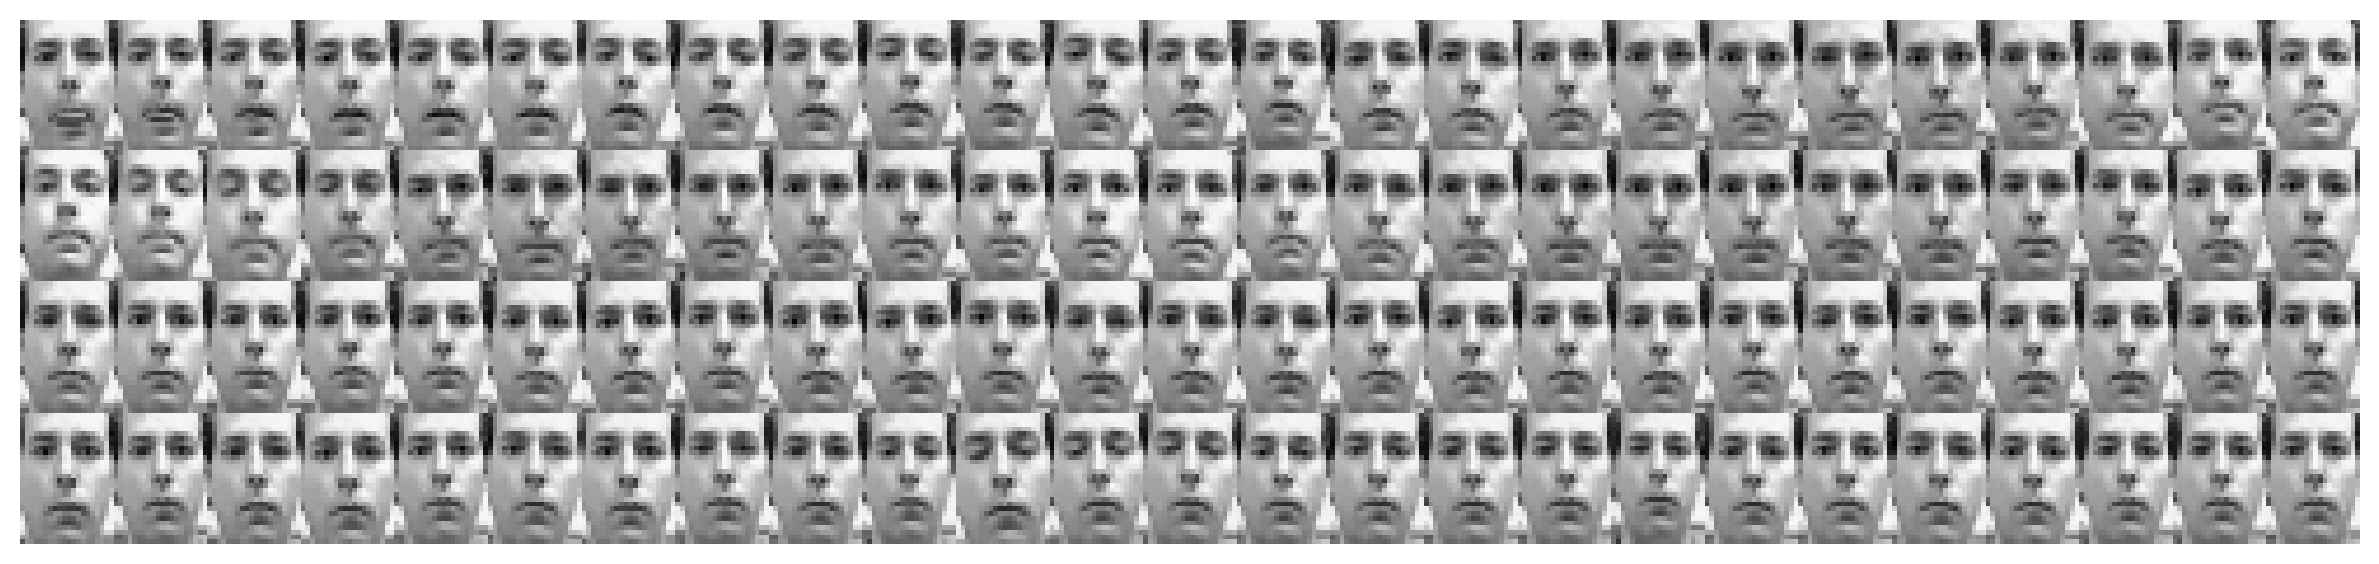

In [7]:
### МОЙ КОД ###
# выведем изображения начального датасета

img_rows, img_cols = 28, 20 # размерность изображения

def show_examples(data, n=None, n_cols=20):
    """
    Функция принимает на вход датасет с изображениями, количество изображений для вывода,
    количество колонок для вывода (это необходимо, если изображений слишком много).
    Функция выводит указанное количество изображений, используя уазанное количество
    колонок для вывода.
    """

    # если количество изображений не указано, то выводим весь датасет
    if n is None:
        n = len(data)    
    
    # расчитываем необходимое кол-во строк для вывода
    n_rows = int(np.ceil(n / float(n_cols)))
    # задаем фигуру (фон заполним 0, т.е. черным цветом)
    figure = np.zeros((img_rows * n_rows, img_cols * n_cols))
    # выводим изображения, раскидывая их по строкам и колонкам
    for k, x in enumerate(data[:n]):
        r = k // n_cols
        c = k % n_cols
        figure[r * img_rows: (r + 1) * img_rows,
               c * img_cols: (c + 1) * img_cols] = x
        
    plt.figure(figsize=(12, 10))
    plt.imshow(figure, cmap='gray')
    plt.axis("off")
    plt.tight_layout()

# выведем 100 изображений
show_examples(data, n=100, n_cols=25)

In [8]:
x_train = FreyDataset(data[:-300]) ###   МОЙ КОД ЗДЕСЬ  ###
x_val = FreyDataset(data[-300:]) ###   МОЙ КОД ЗДЕСЬ  ###
print(f"Training instances: {len(x_train)}")
print(f"Validation instances: {len(x_val)}")

Training instances: 1665
Validation instances: 300


In [9]:
batch_size = 64

### МОЙ КОД НИЖЕ ###
train_loader = DataLoader(
    x_train,
    batch_size=batch_size,
    shuffle=True
) 
### МОЙ КОД НИЖЕ ###
val_loader = DataLoader(
    x_val,
    batch_size=batch_size,
    shuffle=False
) 

In [10]:
kernel_size = 4
stride = 1
padding = 0
init_kernel = 16 

# Вариационныей автоэнкодер

## Задание 2. Допишите трюк репараметризации в функции `reparameterize`. 

*Подробнее о трюке можно узнать в [дополнительных материалах](https://drive.google.com/file/d/18LWM4jROW6A89B7XEpH6w66M5BomGUKn/view?usp=sharing).*

In [11]:
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
 
        # энкодер
        self.enc1 = nn.Conv2d(
            in_channels=1, out_channels=init_kernel, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_kernel, out_channels=init_kernel*2, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_kernel*2, out_channels=init_kernel*4, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_kernel*4, out_channels=init_kernel*8, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.enc5 = nn.Conv2d(
            in_channels=init_kernel*8, out_channels=init_kernel, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        # декодер 
        self.dec1 = nn.ConvTranspose2d(
            in_channels=init_kernel, out_channels=init_kernel*8, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_kernel*8, out_channels=init_kernel*4, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_kernel*4, out_channels=init_kernel*2, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_kernel*2, out_channels=init_kernel, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.dec5 = nn.ConvTranspose2d(
            in_channels=init_kernel, out_channels=1, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
    def reparameterize(self, mu, log_var):
        
        ###   МОЙ КОД ЗДЕСЬ   ###
        """
        :param mu: среднее значение из скрытого пространства кодировщика
        :param log_var: логарифмическая дисперсия из скрытого пространства кодировщика
        """
        std = torch.exp(0.5*log_var) # стандартное отклонение
        eps = torch.randn_like(std) # так как нам нужен одинаковый размер
        sample = mu + (eps * std) 
        
        return sample
 
    def forward(self, x):
        # кодирование
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = self.enc5(x)
        # сэмплирование среднего и logvar
        mu = x
        log_var = x
        # получаем латентное предстваление через репораметризацию
        z = self.reparameterize(mu, log_var)
 
        # декодирование
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        reconstruction = torch.sigmoid(self.dec5(x))
        return reconstruction, mu, log_var

In [12]:
lr = 0.001
epochs = 20
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
### МОЙ КОД НИЖЕ ### 
device=torch.device('mps') # включаем видеоядра MacBook c ARM

In [13]:
model = ConvVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

## Задание 3. Прежде, чем перейти к обучению модели, определите функцию потерь VAE.

In [14]:
def final_loss(bce_loss, mu, logvar):

    ###   МОЙ КОД ЗДЕСЬ   ###
    """
    Эта функция добавляет потери при реконструкции (BCELoss) и 
    KL-дивергенцию (дивергенция Кульбака-Лейблера).
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: потери при реконструкции
    :param mu: среднее значение из скрытого вектора
    :param logvar: логарифмическая дисперсия скрытого вектора
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

## Обучение модели

In [15]:
def fit(model, dataloader, train_data): ### МОЙ КОД - ДОБАВЛЕН параметр train_data
    """
    Функция принимает на вход модель, тренировочный даталоадер и тренировочный датасет,
    возвращает loss на обучении.
    """
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data= data
        data = data.to(device)
        data = data
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

In [16]:
def validate(model, dataloader, val_data): ### МОЙ КОД - ДОБАВЛЕН параметр val_data
    """
    Функция принимает на вход модель, валидационный даталоадер и валидационный датасет,
    возвращает loss на валидации, сохраняет изображение с номером эпохи, где представлены картинки 
    последнего батча и сгенерированные на их основе новые изображения.
    """
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data= data
            data = data.to(device)
            data = data
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if i == int(len(val_data)/dataloader.batch_size) - 1:
                num_rows = 8
                both = torch.cat((data[:8], 
                                  reconstruction[:8]))
                save_image(both.cpu(), f"val_images/output{epoch}.png", nrow=num_rows)
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

In [17]:
train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, train_loader, x_train)
    val_epoch_loss = validate(model, val_loader, x_val)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")

Epoch 1 of 20


27it [00:01, 22.81it/s]                        
5it [00:00, 38.99it/s]               


Train Loss: 391.6964
Val Loss: 382.7726
Epoch 2 of 20


27it [00:00, 47.52it/s]                        
5it [00:00, 155.87it/s]              


Train Loss: 375.1237
Val Loss: 364.0394
Epoch 3 of 20


27it [00:00, 48.55it/s]                        
5it [00:00, 151.75it/s]              


Train Loss: 362.8902
Val Loss: 357.3613
Epoch 4 of 20


27it [00:00, 48.88it/s]                        
5it [00:00, 158.58it/s]              


Train Loss: 358.7556
Val Loss: 354.6715
Epoch 5 of 20


27it [00:00, 49.03it/s]                        
5it [00:00, 159.63it/s]              


Train Loss: 356.6222
Val Loss: 353.4723
Epoch 6 of 20


27it [00:00, 48.90it/s]                        
5it [00:00, 159.30it/s]              


Train Loss: 355.3796
Val Loss: 354.2216
Epoch 7 of 20


27it [00:00, 49.12it/s]                        
5it [00:00, 157.39it/s]              


Train Loss: 354.7973
Val Loss: 351.7254
Epoch 8 of 20


27it [00:00, 49.01it/s]                        
5it [00:00, 156.62it/s]              


Train Loss: 353.9825
Val Loss: 351.2891
Epoch 9 of 20


27it [00:00, 48.81it/s]                        
5it [00:00, 159.11it/s]              


Train Loss: 353.4268
Val Loss: 352.0908
Epoch 10 of 20


27it [00:00, 48.98it/s]                        
5it [00:00, 154.45it/s]              


Train Loss: 353.3199
Val Loss: 351.7987
Epoch 11 of 20


27it [00:00, 45.15it/s]                        
5it [00:00, 138.05it/s]              


Train Loss: 353.0562
Val Loss: 351.4700
Epoch 12 of 20


27it [00:00, 48.68it/s]                        
5it [00:00, 152.24it/s]              


Train Loss: 352.8949
Val Loss: 351.2842
Epoch 13 of 20


27it [00:00, 43.93it/s]                        
5it [00:00, 145.68it/s]              


Train Loss: 352.7988
Val Loss: 351.7974
Epoch 14 of 20


27it [00:00, 47.23it/s]                        
5it [00:00, 154.27it/s]              


Train Loss: 352.7232
Val Loss: 351.6833
Epoch 15 of 20


27it [00:00, 48.66it/s]                        
5it [00:00, 158.29it/s]              


Train Loss: 352.7375
Val Loss: 350.8797
Epoch 16 of 20


27it [00:00, 48.76it/s]                        
5it [00:00, 156.39it/s]              


Train Loss: 352.5794
Val Loss: 351.0099
Epoch 17 of 20


27it [00:00, 48.96it/s]                        
5it [00:00, 159.83it/s]              


Train Loss: 352.6307
Val Loss: 351.0521
Epoch 18 of 20


27it [00:00, 48.95it/s]                        
5it [00:00, 157.86it/s]              


Train Loss: 352.5538
Val Loss: 350.7149
Epoch 19 of 20


27it [00:00, 48.76it/s]                        
5it [00:00, 156.20it/s]              


Train Loss: 352.5349
Val Loss: 350.6236
Epoch 20 of 20


27it [00:00, 48.99it/s]                        
5it [00:00, 158.31it/s]              

Train Loss: 352.4848
Val Loss: 350.8242


## Визуализация полученных изображений

In [18]:
from PIL import Image
import matplotlib.pyplot as plt

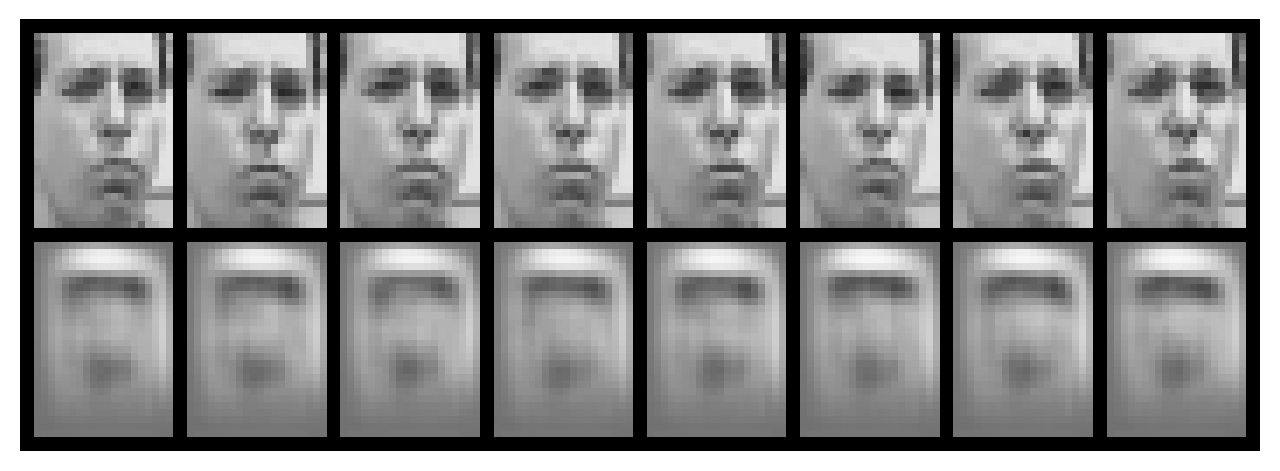

In [19]:
### МОЙ КОД ###
# 1я эпоха
image_1 = Image.open("val_images/output1.png")
plt.imshow(image_1)
plt.xticks([])
plt.yticks([]);

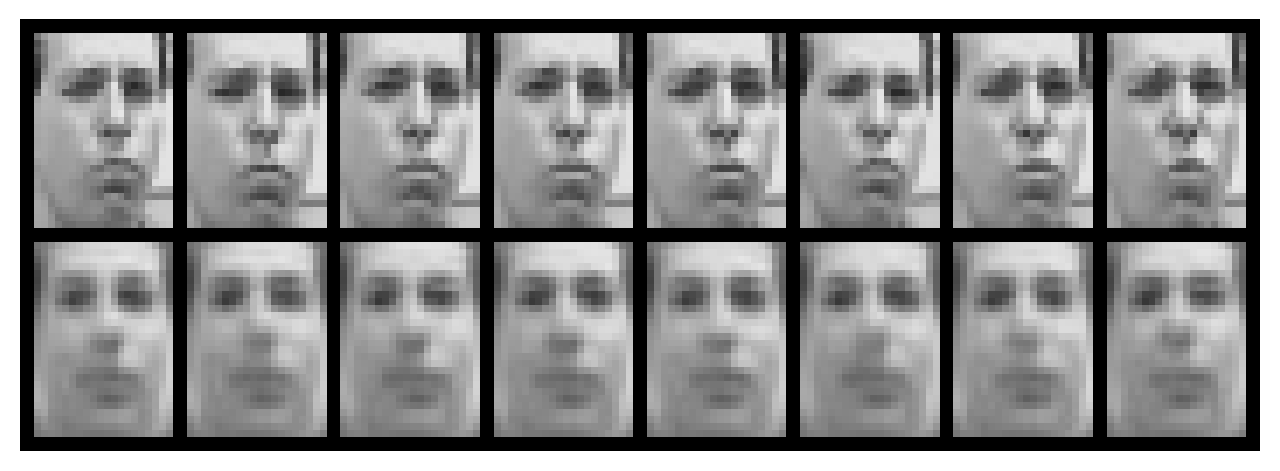

In [20]:
# 10я эпоха
image_10 = Image.open("val_images/output10.png")
plt.imshow(image_10)
plt.xticks([])
plt.yticks([]);

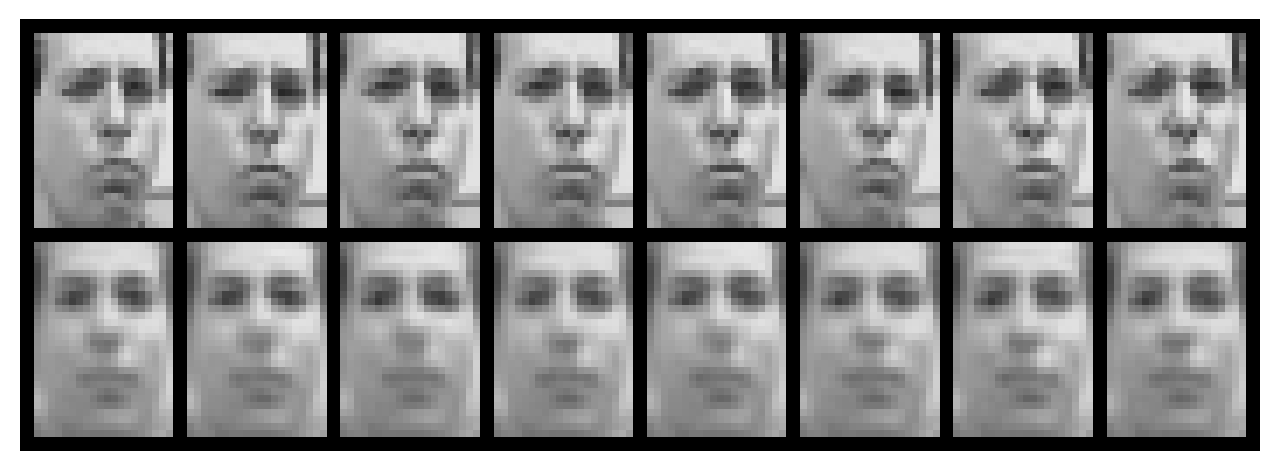

In [21]:
# 19я эпоха
image_19 = Image.open("val_images/output19.png")
plt.imshow(image_19)
plt.xticks([])
plt.yticks([]);

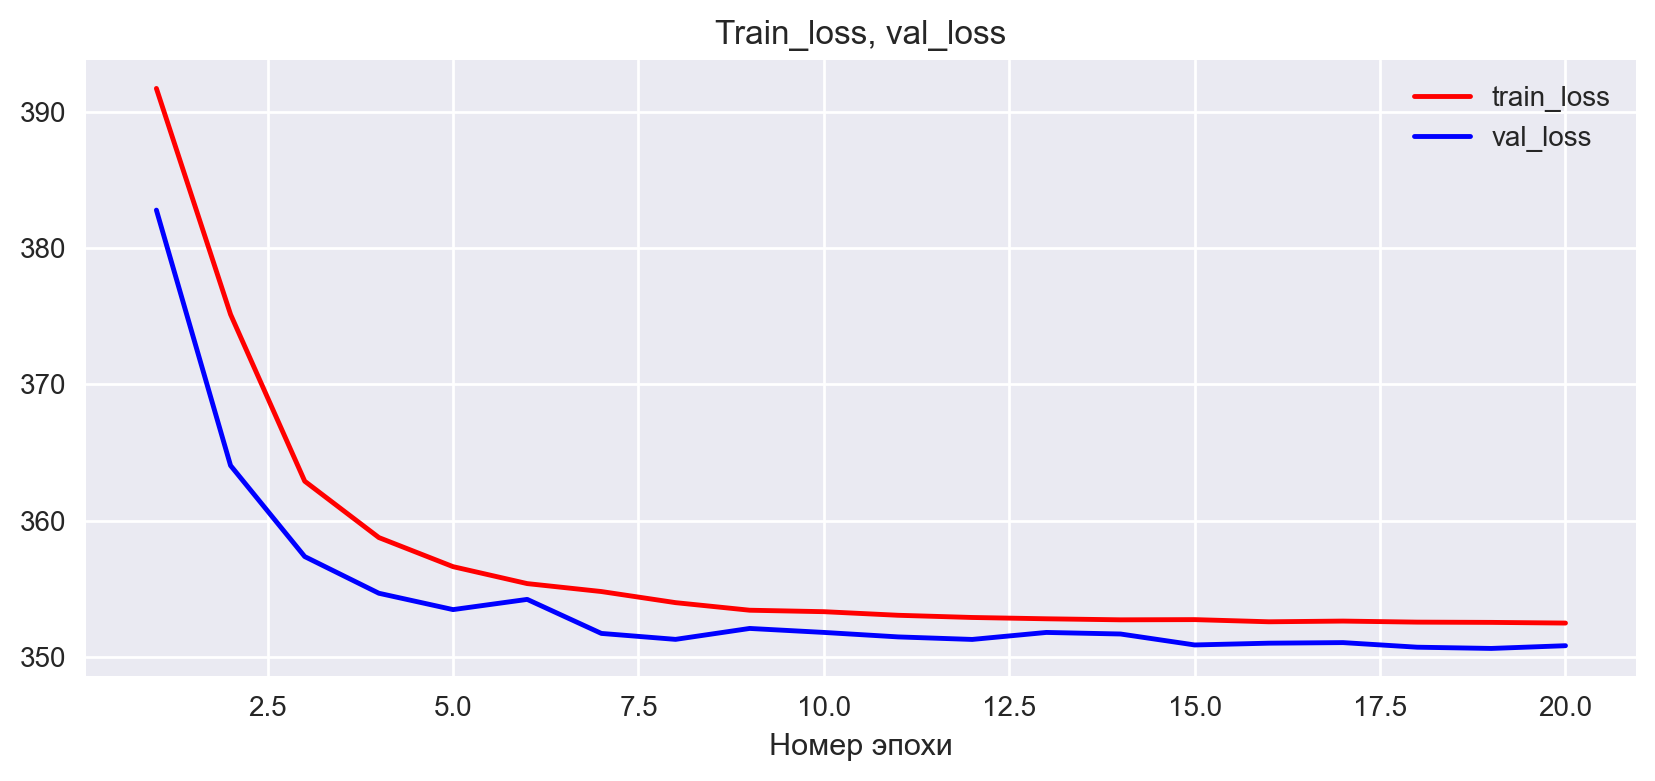

In [22]:
### МОЙ КОД ###
# визуализируем результаты обучения
plt.figure(figsize=(10, 4))

plt.plot(range(1, len(train_loss) + 1), train_loss, color="r")
plt.plot(range(1, len(val_loss) + 1), val_loss, color="b")
plt.xlabel("Номер эпохи")
plt.legend(['train_loss', 'val_loss'], loc='best')
plt.title("Train_loss, val_loss")
plt.show()

# Выводы:

- в ноутбуке выполнено все 3 задания
- на 20 эпохах достигнут показатель примерно 352 loss на валидации
- после 10-12 эпохи метрики стабилизируются и практически не падают, что также подтверждается увеличением количества эпох до 100
- это также видно на примере сгенерированных изображений в начале, середине и конце обучения